# Sparkify - Prediction of Customer Churn

In [84]:
# import libraries
from datetime import datetime

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, ltrim, rtrim, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType

#from pyspark.ml import Pipeline
#from pyspark.ml.classification import LogisticRegression
#from pyspark.ml.evaluation import MulticlassClassificationEvaluator
#from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
#from pyspark.ml.regression import LinearRegression
#from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import re

In [3]:
# create Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Model") \
    .getOrCreate()

## Load and Clean Dataset

In [4]:
df = spark.read.json('mini_sparkify_event_data.json') # mini dataset to run code on local machine
df.persist() # lazy evaluation

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Investigate Session ID & User ID

In [6]:
id_list = ['sessionId','userId']

print('The dataset has {} rows.\n'.format(df.count()))

for idx in id_list:
    # min and max values
    df.agg(min(col(idx)), max(col(idx))).show()
    # count and share of missing values
    null_count = df.where((df[idx].isNull()) | (df[idx] == '')).count()
    null_share = (null_count/df.count())*100
    print('{} rows ({}%) have missing {}.\n'.format(null_count, "{:.2f}".format(null_share), idx))

The dataset has 286500 rows.

+--------------+--------------+
|min(sessionId)|max(sessionId)|
+--------------+--------------+
|             1|          2474|
+--------------+--------------+

0 rows (0.00%) have missing sessionId.

+-----------+-----------+
|min(userId)|max(userId)|
+-----------+-----------+
|           |         99|
+-----------+-----------+

8346 rows (2.91%) have missing userId.



In [7]:
# page visits for rows with missing userId
df.select(['userId','page','ts']) \
  .where(col('userId')=='') \
  .groupby('page') \
  .count() \
  .sort(desc('count')) \
  .show()

+-------------------+-----+
|               page|count|
+-------------------+-----+
|               Home| 4375|
|              Login| 3241|
|              About|  429|
|               Help|  272|
|           Register|   18|
|              Error|    6|
|Submit Registration|    5|
+-------------------+-----+



**Conclusion:** Since the events with missing user IDs seem to be attributed to users that are not logged in (most of these events are located at pages "Home" & "Login"), these events will be excluded from further analyses.

In [5]:
# drop rows with missing userId
df_clean = df.filter(df['userId'] != '')
print('The clean dataset is reduced to {} rows.\n'.format(df_clean.count()))

The clean dataset is reduced to 278154 rows.



### Investigate Length

In [10]:
# filter for pages with length = None
no_length_pages = df_clean.filter(df_clean.length.isNull()) \
                          .select(col('page') \
                          .alias('no_length_pages')) \
                          .dropDuplicates()

# get a list of possible pages that could be visited
all_pages = df_clean.select('page').dropDuplicates()

print('These pages are connected to empty length values:')
for row in list(no_length_pages.sort('page').collect()):
    print(row[0])

# find values in all_pages that are not in no_length_pages
# these are the pages that are always connected to a length value
for row in set(all_pages.collect()) - set(no_length_pages.collect()):
    print('\nThese pages always have the column length filled:\n' + row.page)

These pages are connected to empty length values:
About
Add Friend
Add to Playlist
Cancel
Cancellation Confirmation
Downgrade
Error
Help
Home
Logout
Roll Advert
Save Settings
Settings
Submit Downgrade
Submit Upgrade
Thumbs Down
Thumbs Up
Upgrade

These pages always have the column length filled:
NextSong


**Conclusion:** Data seems to be valid since the empty length values are always connected to pages that are **not** playing songs. No cleaning necessary.

### Convert Timestamp to Datetime

In [6]:
# user defined function to convert timestamp to datetime
datetime_converter = udf(lambda x: datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

# create new column 'datetime' by applying datetime_converter to column 'ts'
df_clean = df_clean.withColumn('datetime', datetime_converter(df_clean['ts']))

df_clean.select('ts','datetime').show()

+-------------+-------------------+
|           ts|           datetime|
+-------------+-------------------+
|1538352117000|2018-10-01 00:01:57|
|1538352180000|2018-10-01 00:03:00|
|1538352394000|2018-10-01 00:06:34|
|1538352416000|2018-10-01 00:06:56|
|1538352676000|2018-10-01 00:11:16|
|1538352678000|2018-10-01 00:11:18|
|1538352886000|2018-10-01 00:14:46|
|1538352899000|2018-10-01 00:14:59|
|1538352905000|2018-10-01 00:15:05|
|1538353084000|2018-10-01 00:18:04|
|1538353146000|2018-10-01 00:19:06|
|1538353150000|2018-10-01 00:19:10|
|1538353218000|2018-10-01 00:20:18|
|1538353375000|2018-10-01 00:22:55|
|1538353376000|2018-10-01 00:22:56|
|1538353441000|2018-10-01 00:24:01|
|1538353576000|2018-10-01 00:26:16|
|1538353668000|2018-10-01 00:27:48|
|1538353687000|2018-10-01 00:28:07|
|1538353744000|2018-10-01 00:29:04|
+-------------+-------------------+
only showing top 20 rows



### Extract Date from Datetime

In [7]:
# create new columns 'year', 'month' & 'day' by splitting the column datetime by hyphen & space
df_clean = df_clean.withColumn('date', split('datetime',' ')[0])

df_clean.select('datetime','date').show()

+-------------------+----------+
|           datetime|      date|
+-------------------+----------+
|2018-10-01 00:01:57|2018-10-01|
|2018-10-01 00:03:00|2018-10-01|
|2018-10-01 00:06:34|2018-10-01|
|2018-10-01 00:06:56|2018-10-01|
|2018-10-01 00:11:16|2018-10-01|
|2018-10-01 00:11:18|2018-10-01|
|2018-10-01 00:14:46|2018-10-01|
|2018-10-01 00:14:59|2018-10-01|
|2018-10-01 00:15:05|2018-10-01|
|2018-10-01 00:18:04|2018-10-01|
|2018-10-01 00:19:06|2018-10-01|
|2018-10-01 00:19:10|2018-10-01|
|2018-10-01 00:20:18|2018-10-01|
|2018-10-01 00:22:55|2018-10-01|
|2018-10-01 00:22:56|2018-10-01|
|2018-10-01 00:24:01|2018-10-01|
|2018-10-01 00:26:16|2018-10-01|
|2018-10-01 00:27:48|2018-10-01|
|2018-10-01 00:28:07|2018-10-01|
|2018-10-01 00:29:04|2018-10-01|
+-------------------+----------+
only showing top 20 rows



### Extract Year, Month & Day from Date

In [58]:
# create new columns 'year', 'month' & 'day' by splitting the column date by hyphen
df_clean = df_clean.withColumn('year', split('date','-')[0])
df_clean = df_clean.withColumn('month', split('date','-')[1])
df_clean = df_clean.withColumn('day', split('date','-')[2])

df_clean.select('datetime','year','month','day').show()

+-------------------+----+-----+---+
|           datetime|year|month|day|
+-------------------+----+-----+---+
|2018-10-01 00:01:57|2018|   10| 01|
|2018-10-01 00:03:00|2018|   10| 01|
|2018-10-01 00:06:34|2018|   10| 01|
|2018-10-01 00:06:56|2018|   10| 01|
|2018-10-01 00:11:16|2018|   10| 01|
|2018-10-01 00:11:18|2018|   10| 01|
|2018-10-01 00:14:46|2018|   10| 01|
|2018-10-01 00:14:59|2018|   10| 01|
|2018-10-01 00:15:05|2018|   10| 01|
|2018-10-01 00:18:04|2018|   10| 01|
|2018-10-01 00:19:06|2018|   10| 01|
|2018-10-01 00:19:10|2018|   10| 01|
|2018-10-01 00:20:18|2018|   10| 01|
|2018-10-01 00:22:55|2018|   10| 01|
|2018-10-01 00:22:56|2018|   10| 01|
|2018-10-01 00:24:01|2018|   10| 01|
|2018-10-01 00:26:16|2018|   10| 01|
|2018-10-01 00:27:48|2018|   10| 01|
|2018-10-01 00:28:07|2018|   10| 01|
|2018-10-01 00:29:04|2018|   10| 01|
+-------------------+----+-----+---+
only showing top 20 rows



### Extract Weekday from Timestamp

In [91]:
# user defined function to extract weekday from date
weekday_converter = udf(lambda x: datetime.weekday(datetime.strptime(datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"), '%Y-%m-%d %H:%M:%S')))

# create new column 'weekday' by applying weekday_converter to column 'ts'
df_clean = df_clean.withColumn('weekday', weekday_converter(df_clean['ts']))

df_clean.select('ts','date','weekday').show()

+-------------+----------+-------+
|           ts|      date|weekday|
+-------------+----------+-------+
|1538352117000|2018-10-01|      0|
|1538352180000|2018-10-01|      0|
|1538352394000|2018-10-01|      0|
|1538352416000|2018-10-01|      0|
|1538352676000|2018-10-01|      0|
|1538352678000|2018-10-01|      0|
|1538352886000|2018-10-01|      0|
|1538352899000|2018-10-01|      0|
|1538352905000|2018-10-01|      0|
|1538353084000|2018-10-01|      0|
|1538353146000|2018-10-01|      0|
|1538353150000|2018-10-01|      0|
|1538353218000|2018-10-01|      0|
|1538353375000|2018-10-01|      0|
|1538353376000|2018-10-01|      0|
|1538353441000|2018-10-01|      0|
|1538353576000|2018-10-01|      0|
|1538353668000|2018-10-01|      0|
|1538353687000|2018-10-01|      0|
|1538353744000|2018-10-01|      0|
+-------------+----------+-------+
only showing top 20 rows



### Extract Hour from Datetime

In [46]:
# user defined function to integer-convert a value
convert_to_integer = udf(lambda x : int(x), IntegerType())

# create new column 'hour' by splitting the column datetime by space & colon and applying convert_to_integer
df_clean = df_clean.withColumn('hour', split(split('datetime',' ')[1],':')[0])
df_clean = df_clean.withColumn('hour', convert_to_integer(df_clean['hour']))

df_clean.select('datetime','hour').show()

+-------------------+----+
|           datetime|hour|
+-------------------+----+
|2018-10-01 00:01:57|   0|
|2018-10-01 00:03:00|   0|
|2018-10-01 00:06:34|   0|
|2018-10-01 00:06:56|   0|
|2018-10-01 00:11:16|   0|
|2018-10-01 00:11:18|   0|
|2018-10-01 00:14:46|   0|
|2018-10-01 00:14:59|   0|
|2018-10-01 00:15:05|   0|
|2018-10-01 00:18:04|   0|
|2018-10-01 00:19:06|   0|
|2018-10-01 00:19:10|   0|
|2018-10-01 00:20:18|   0|
|2018-10-01 00:22:55|   0|
|2018-10-01 00:22:56|   0|
|2018-10-01 00:24:01|   0|
|2018-10-01 00:26:16|   0|
|2018-10-01 00:27:48|   0|
|2018-10-01 00:28:07|   0|
|2018-10-01 00:29:04|   0|
+-------------------+----+
only showing top 20 rows



### Extract State from Location

In [10]:
# create new column 'state' by splitting the column 'location' by comma
df_clean = df_clean.withColumn('state', ltrim(rtrim(split('location',',')[1])))

df_clean.select('location','state').show()

+--------------------+-----+
|            location|state|
+--------------------+-----+
|     Bakersfield, CA|   CA|
|Boston-Cambridge-...|MA-NH|
|     Bakersfield, CA|   CA|
|Boston-Cambridge-...|MA-NH|
|     Bakersfield, CA|   CA|
|Boston-Cambridge-...|MA-NH|
|Boston-Cambridge-...|MA-NH|
|     Bakersfield, CA|   CA|
|     Bakersfield, CA|   CA|
|     Bakersfield, CA|   CA|
|Boston-Cambridge-...|MA-NH|
|Boston-Cambridge-...|MA-NH|
|     Bakersfield, CA|   CA|
|Boston-Cambridge-...|MA-NH|
|Boston-Cambridge-...|MA-NH|
|     Bakersfield, CA|   CA|
|Boston-Cambridge-...|MA-NH|
|     Tallahassee, FL|   FL|
|     Bakersfield, CA|   CA|
|Boston-Cambridge-...|MA-NH|
+--------------------+-----+
only showing top 20 rows



## Exploratory Data Analysis

In [53]:
# prepare functions for exploratory data analysis

colors = ['paleturquoise', 'lightseagreen']


def show_descriptives(df, col):
    '''
    '''
    df.select(col).describe().show()
    
    
def plot_histogram(df, col):
    '''
    '''
    ax = sns.displot(df.toPandas()[col], kde=True, palette=colors)
    ax.set(xlabel=col.replace('_',' ').title(), ylabel='Density')
    
    plt.show()
    
    
def plot_bar_chart(df, x_col, y_col, size=(8,8)):
    '''
    '''
    # wrangle data
    x = df.toPandas().sort_values([x_col], ascending=False).reset_index(drop=True)[x_col]
    y = df.toPandas()[y_col]
    
    # figure settings
    fig = plt.subplots(figsize=size)

    ax = sns.barplot(x=x, y=y, palette=color)
    ax.set(xlabel=x_col.replace('_',' ').title(),
           ylabel=y_col.replace('_',' ').title())
    
    plt.show()    
    

def plot_bar_chart_with_legend(df, x_col, y_col, legend, x_lim=0, y_lim=250000):
    '''
    '''
    # wrangle data
    x = df.toPandas().sort_values([x_col], ascending=False).reset_index(drop=True)[x_col]
    y = df.toPandas()[y_col]
    
    # figure settings
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,8), sharey=True)
    
    # first subplot
    ax1 = sns.barplot(x=x, y=y, ax=ax1, hue=df.toPandas()[legend], dodge=False, palette=colors)
    ax1.set(xlabel=x_col.replace('_',' ').title(),
            ylabel=y_col.replace('_',' ').title())
    ax1.legend(title=legend.replace('_',' ').title())
    
    # second subplot
    ax2 = sns.barplot(x=x, y=y, ax=ax2, hue=df.toPandas()[legend], dodge=False, palette=colors)
    ax2.set(xlabel=x_col.replace('_',' ').title(),
            ylabel=y_col.replace('_',' ').title(),
            xlim=(x_lim, y_lim))
    ax2.legend(title=legend.replace('_',' ').title())
    
    plt.show()
    
    
def plot_pie_chart(df, val_col, label_col, color=colors):
    '''
    '''
    sizes = df.toPandas()[val_col]
    labels = df.toPandas()[label_col]
    
    def absolute_value(val):
        a  = "{:.0f}".format(np.round(val/100.*sizes.sum(), 0))
        return a
    
    # figure settings
    fig = plt.figure(figsize=[8,8])
    ax = fig.add_subplot(111)
    
    ax.pie(sizes, labels=labels, autopct=absolute_value, colors=colors)
    ax.set_title(label_col.replace('_',' ').title())
    plt.show()
    
def plot_line_chart(df, x_col, y_col, legend):
    '''
    '''
    # wrangle data
    x = df.toPandas()[x_col]
    y = df.toPandas()[y_col]
    
    hue = df.toPandas()[legend]
    
    # figure settings
    fig = plt.subplots(figsize=(16,8))
    
    ax = sns.lineplot(x=x, y=y, hue=hue)
    ax.set(xlabel=x_col.replace('_',' ').title(),
           ylabel=y_col.replace('_',' ').title())
    ax.tick_params(axis='x', rotation=90)
    ax.legend(title=legend.replace('_',' ').title())
    
    plt.show()

### Pages Types & Method

In [18]:
df_clean.groupby('page','method').count().sort('method','page').show()

+--------------------+------+------+
|                page|method| count|
+--------------------+------+------+
|               About|   GET|   495|
|Cancellation Conf...|   GET|    52|
|           Downgrade|   GET|  2055|
|               Error|   GET|   252|
|                Help|   GET|  1454|
|                Home|   GET| 10082|
|         Roll Advert|   GET|  3933|
|            Settings|   GET|  1514|
|             Upgrade|   GET|   499|
|          Add Friend|   PUT|  4277|
|     Add to Playlist|   PUT|  6526|
|              Cancel|   PUT|    52|
|              Logout|   PUT|  3226|
|            NextSong|   PUT|228108|
|       Save Settings|   PUT|   310|
|    Submit Downgrade|   PUT|    63|
|      Submit Upgrade|   PUT|   159|
|         Thumbs Down|   PUT|  2546|
|           Thumbs Up|   PUT| 12551|
+--------------------+------+------+



Each page type is unambiuously connected to either method 'Get' or 'Put'.

There are 19 different page types.


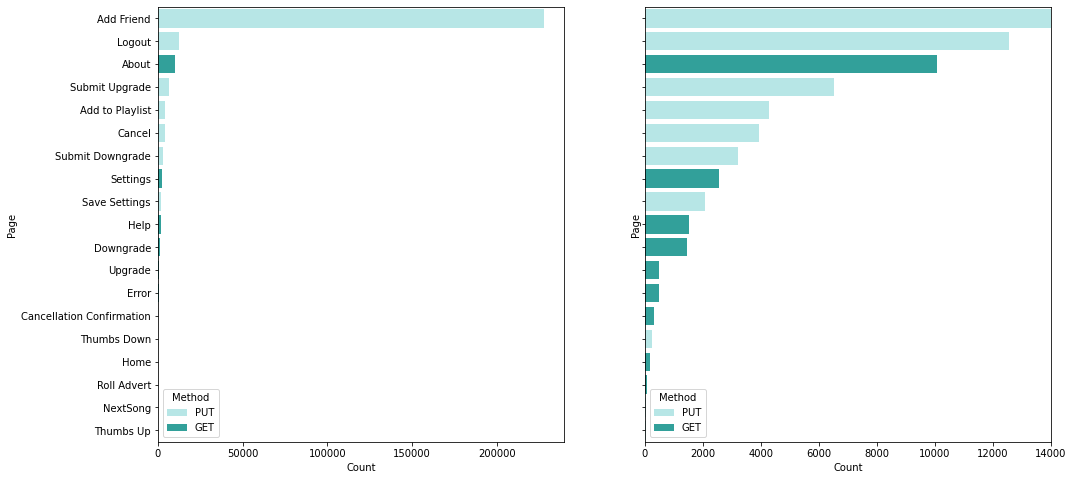

In [19]:
pages_count = df_clean.groupby('page','method').count()

# absolute number of page types
print('There are {} different page types.'.format(pages_count.count()))

# visualization
plot_bar_chart_with_legend(df=pages_count,x_col='count',y_col='page',legend='method', y_lim=14000)

### Level

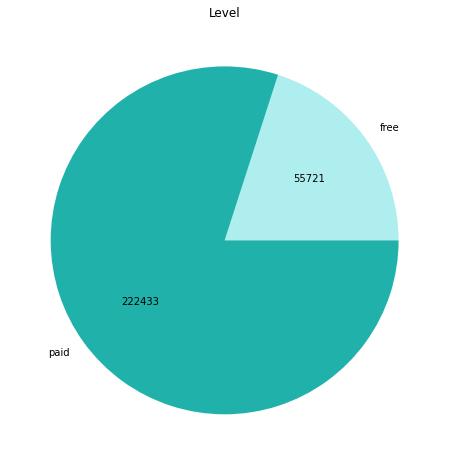

In [20]:
level = df_clean.groupby('level').count()
    
plot_pie_chart(level,'count','level')

### Gender

In [21]:
gender_user_combination = df_clean.select('gender','userId').dropDuplicates().count()
unique_users = df_clean.select('userId').dropDuplicates().count()

if gender_user_combination == unique_users:
    print('Each user is associated with a unique gender in the dataset.')
else:
    print('There are {} gender x user combinations more than there are unique users.'.format(gender_user_combination-unique_users))

Each user is associated with a unique gender in the dataset.


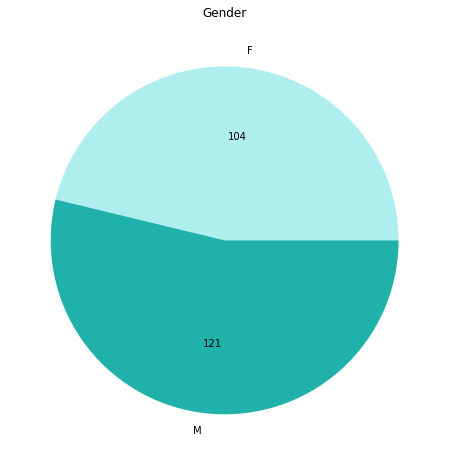

In [22]:
gender = df_clean.select('gender','userId') \
                 .dropDuplicates() \
                 .groupby('gender') \
                 .count()

plot_pie_chart(gender,'count','gender')

### Location

In [23]:
state_user_combination = df_clean.select('state','userId').dropDuplicates().count()
unique_users = df_clean.select('userId').dropDuplicates().count()

if state_user_combination == unique_users:
    print('Each user is associated with a unique state in the dataset.')
else:
    print('There are {} state x user combinations more than there are unique users.'.format(state_user_combination-unique_users))

Each user is associated with a unique state in the dataset.


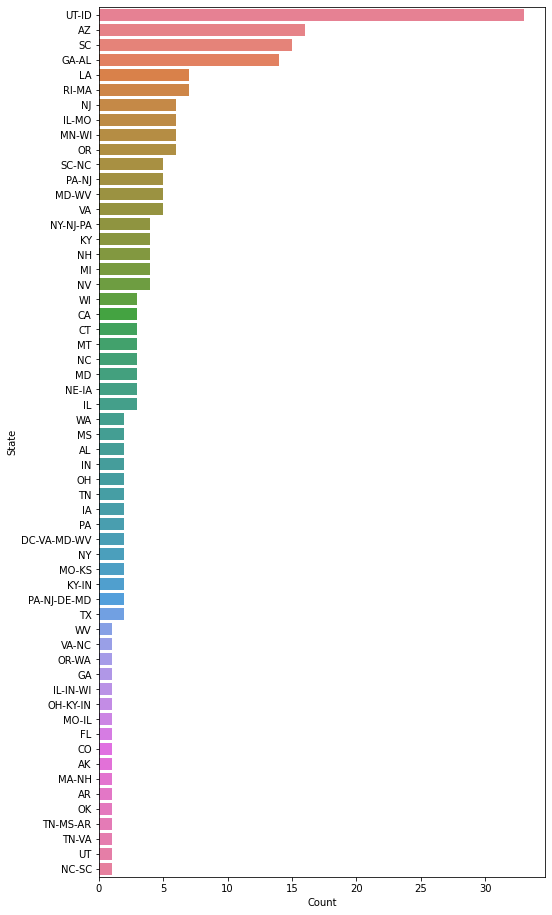

In [24]:
location = df_clean.select('state','userId') \
                 .dropDuplicates() \
                 .groupby('state') \
                 .count()

plot_bar_chart(location,'count','state', size=(8,16), color='husl')

### Unique Sessions per User

+-------+------------------------+
|summary|unique_sessions_per_user|
+-------+------------------------+
|  count|                     225|
|   mean|      14.115555555555556|
| stddev|      14.646884657111562|
|    min|                       1|
|    max|                     107|
+-------+------------------------+



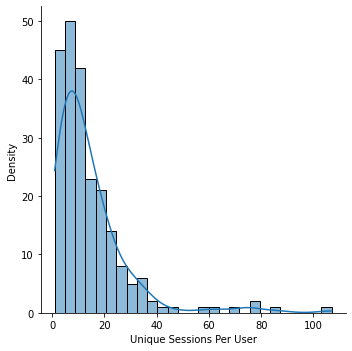

In [23]:
sessions_per_user = df_clean.select('userId','sessionId') \
                            .dropDuplicates() \
                            .groupby('userId') \
                            .count() \
                            .withColumnRenamed('count', 'unique_sessions_per_user')

# descriptives
show_descriptives(sessions_per_user, 'unique_sessions_per_user')
        
# visualization
plot_histogram(sessions_per_user, 'unique_sessions_per_user')

### Items per Session

+-------+------------------+
|summary| items_per_session|
+-------+------------------+
|  count|              2312|
|   mean| 108.4757785467128|
| stddev|123.76252480420018|
|    min|                 0|
|    max|              1321|
+-------+------------------+



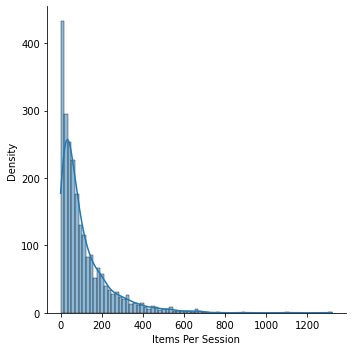

In [24]:
items_per_session = df_clean.groupby('sessionId') \
                            .agg({'itemInSession':'max'}) \
                            .withColumnRenamed('max(itemInSession)', 'items_per_session')

# descriptives
show_descriptives(items_per_session, 'items_per_session')
        
# visualization
plot_histogram(items_per_session, 'items_per_session')

### Length per Item or Session

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



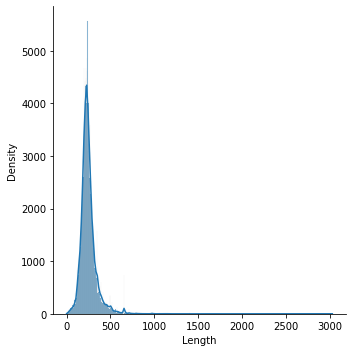

In [25]:
length_per_item = df_clean.filter(col('length').isNotNull()).select('length')

# descriptives
show_descriptives(length_per_item, 'length')
        
# visualization
plot_histogram(length_per_item, 'length')

+-------+------------------------+
|summary|total_length_per_session|
+-------+------------------------+
|  count|                    2253|
|   mean|      25222.202461873054|
| stddev|      28117.169683359738|
|    min|               153.46893|
|    max|       267758.1329100001|
+-------+------------------------+



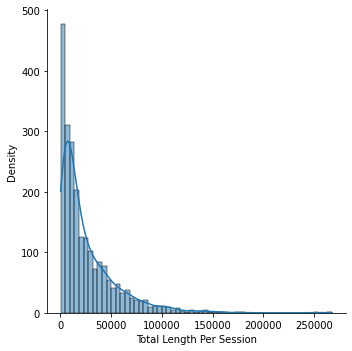

In [26]:
length_per_session = df_clean.filter(col('length').isNotNull()) \
                             .groupby('sessionId') \
                             .agg({'length':'sum'}) \
                             .withColumnRenamed('sum(length)', 'total_length_per_session')

# descriptives
show_descriptives(length_per_session, 'total_length_per_session')
        
# visualization
plot_histogram(length_per_session, 'total_length_per_session')

### Seasonality

In [27]:
df_clean.groupby('date').count().sort('date').collect()

[Row(date='2018-10-01', count=4286),
 Row(date='2018-10-02', count=4453),
 Row(date='2018-10-03', count=3966),
 Row(date='2018-10-04', count=4645),
 Row(date='2018-10-05', count=4485),
 Row(date='2018-10-06', count=3711),
 Row(date='2018-10-07', count=2937),
 Row(date='2018-10-08', count=5137),
 Row(date='2018-10-09', count=5474),
 Row(date='2018-10-10', count=6178),
 Row(date='2018-10-11', count=5623),
 Row(date='2018-10-12', count=5398),
 Row(date='2018-10-13', count=2975),
 Row(date='2018-10-14', count=2629),
 Row(date='2018-10-15', count=5153),
 Row(date='2018-10-16', count=5802),
 Row(date='2018-10-17', count=5235),
 Row(date='2018-10-18', count=5370),
 Row(date='2018-10-19', count=5545),
 Row(date='2018-10-20', count=5697),
 Row(date='2018-10-21', count=3036),
 Row(date='2018-10-22', count=4888),
 Row(date='2018-10-23', count=4300),
 Row(date='2018-10-24', count=5667),
 Row(date='2018-10-25', count=4993),
 Row(date='2018-10-26', count=4296),
 Row(date='2018-10-27', count=3500),
 

**Conclusion:** Seasonality cannot be properly investigated on the small dataset since it includes 2 full months only.

### Time Series of Page Types

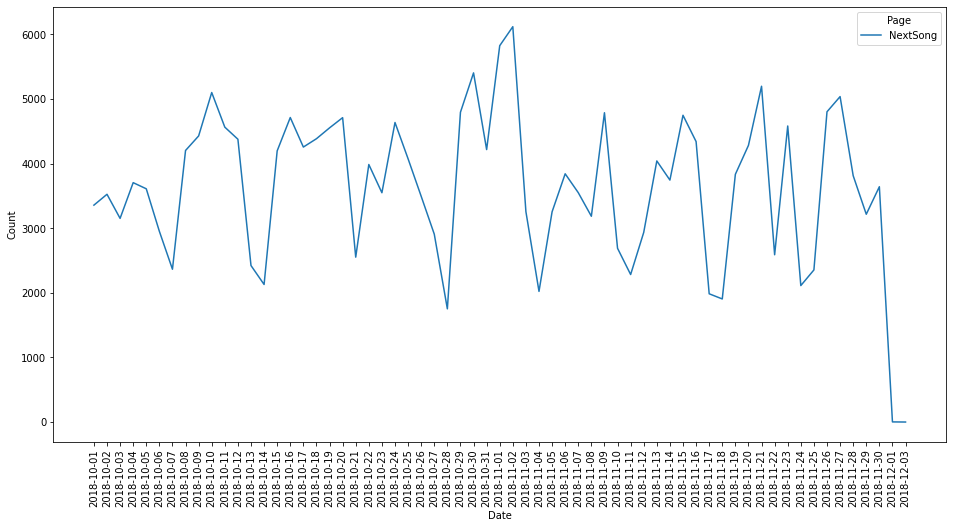

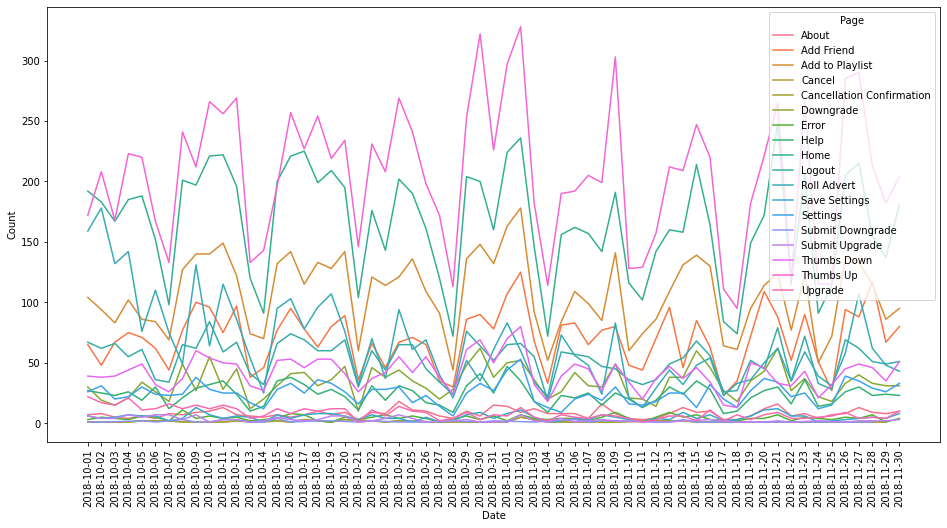

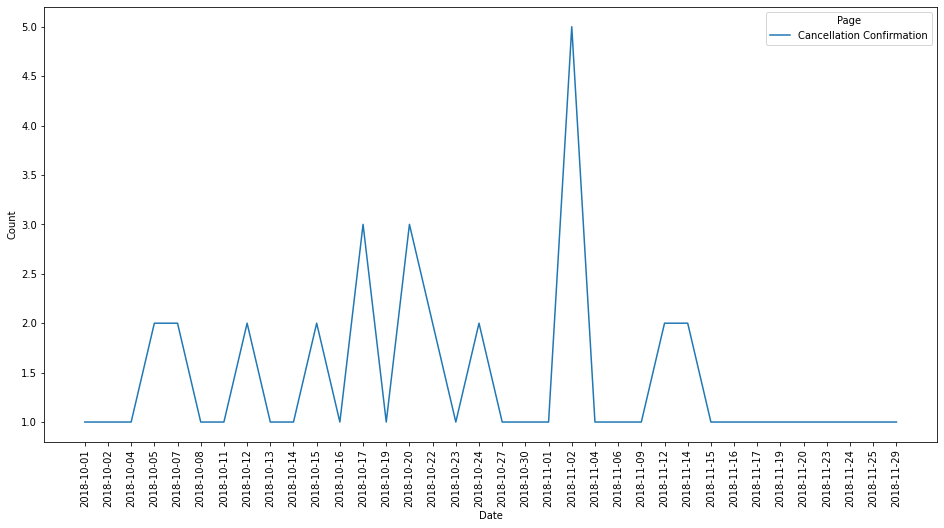

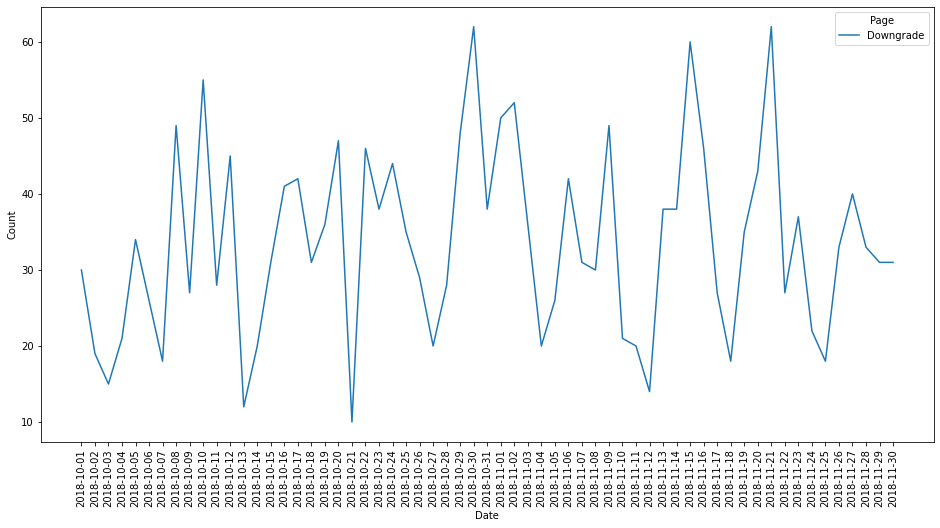

In [57]:
# plot page type 'NextSong' only
events_per_day = df_clean.filter(col('page')=='NextSong').groupby('date','page').count().sort('date','page')

plot_line_chart(events_per_day, 'date', 'count', 'page')

#plot all page types except 'NextSong'
events_per_day = df_clean.filter(col('page')!='NextSong').groupby('date','page').count().sort('date','page')

plot_line_chart(events_per_day, 'date', 'count', 'page')

#plot page type 'Cancellation Confirmation'
events_per_day = df_clean.filter(col('page')=='Cancellation Confirmation').groupby('date','page').count().sort('date','page')

plot_line_chart(events_per_day, 'date', 'count', 'page')

#plot page type 'Downgrade'
events_per_day = df_clean.filter(col('page')=='Downgrade').groupby('date','page').count().sort('date','page')

plot_line_chart(events_per_day, 'date', 'count', 'page')

### Weekday Time Series of Page Type

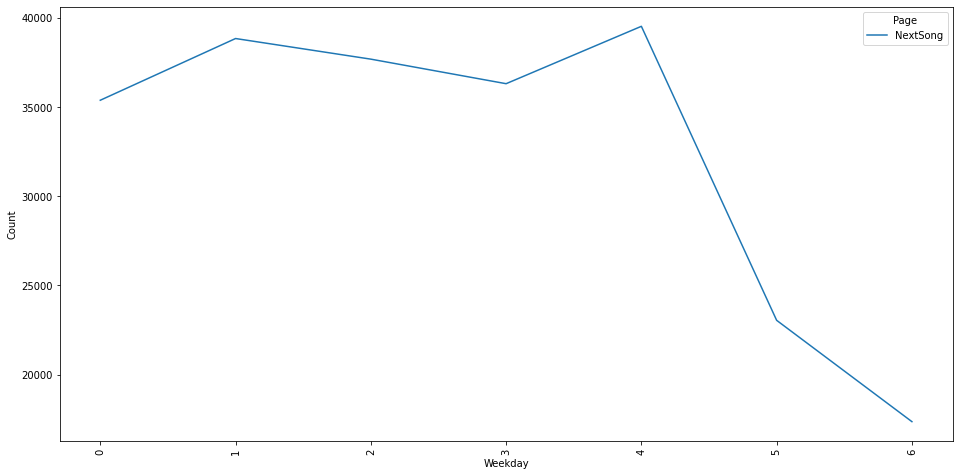

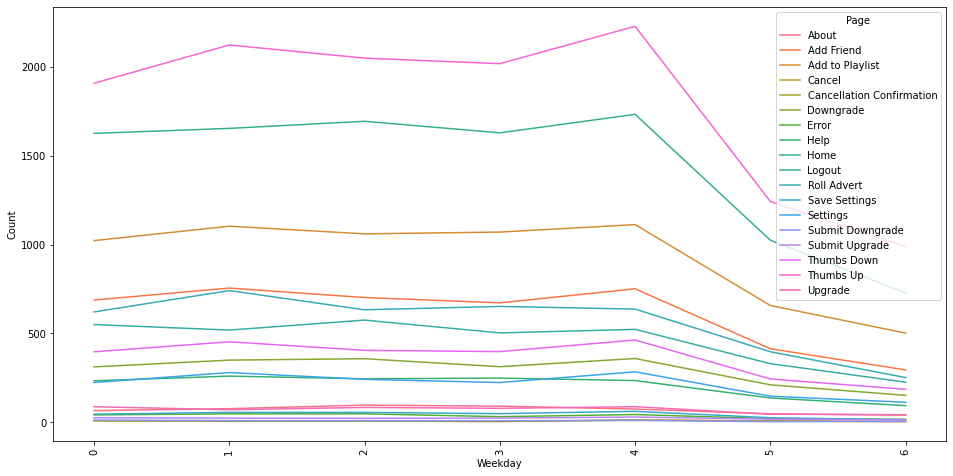

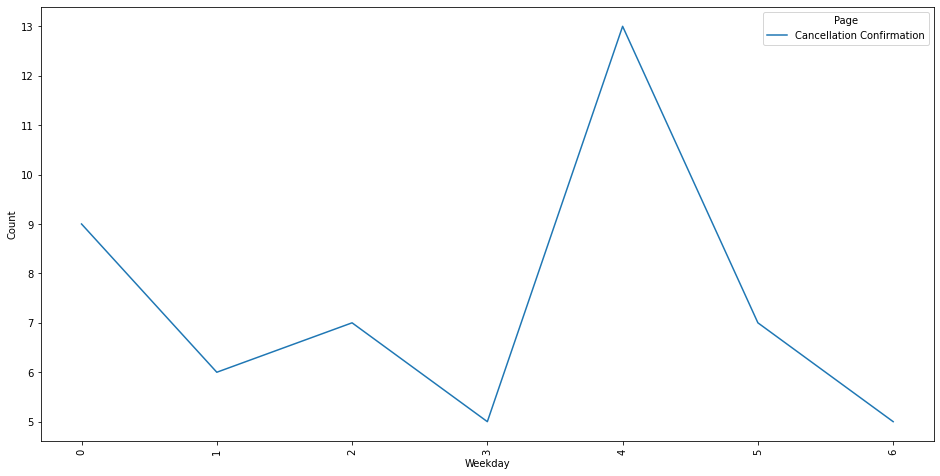

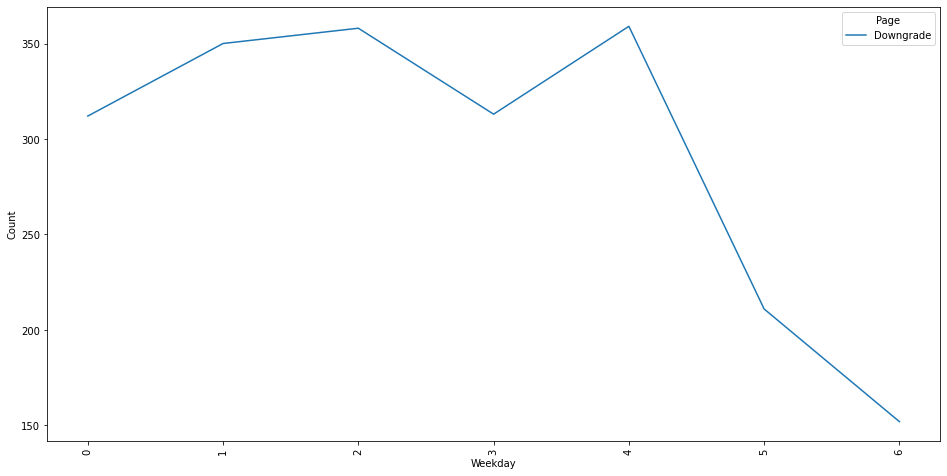

In [92]:
# plot page type 'NextSong' only
events_per_weekday = df_clean.filter(col('page')=='NextSong').groupby('weekday','page').count().sort('weekday','page')

plot_line_chart(events_per_weekday, 'weekday', 'count', 'page')

#plot all page types except 'NextSong'
events_per_weekday = df_clean.filter(col('page')!='NextSong').groupby('weekday','page').count().sort('weekday','page')

plot_line_chart(events_per_weekday, 'weekday', 'count', 'page')

#plot page type 'Cancellation Confirmation'
events_per_weekday = df_clean.filter(col('page')=='Cancellation Confirmation').groupby('weekday','page').count().sort('weekday','page')

plot_line_chart(events_per_weekday, 'weekday', 'count', 'page')

#plot page type 'Downgrade'
events_per_weekday = df_clean.filter(col('page')=='Downgrade').groupby('weekday','page').count().sort('weekday','page')

plot_line_chart(events_per_weekday, 'weekday', 'count', 'page')

### Hourly Time Series of Page Types

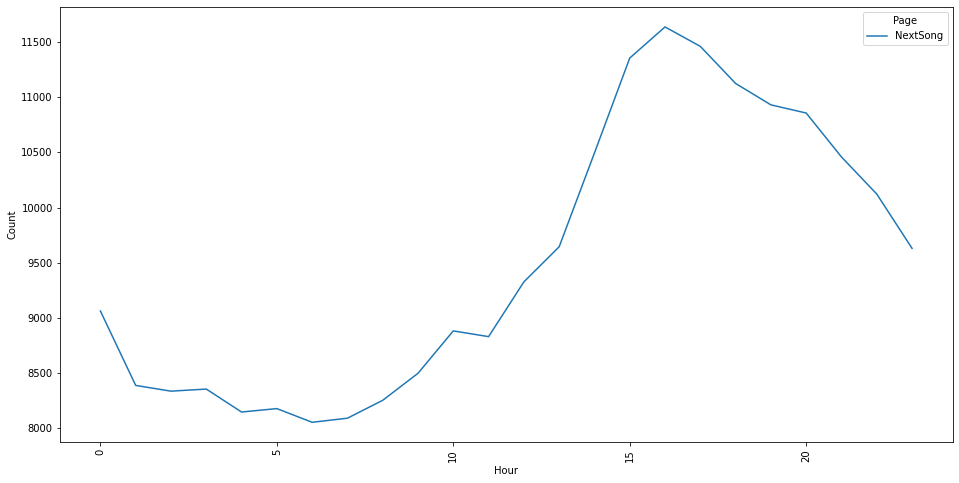

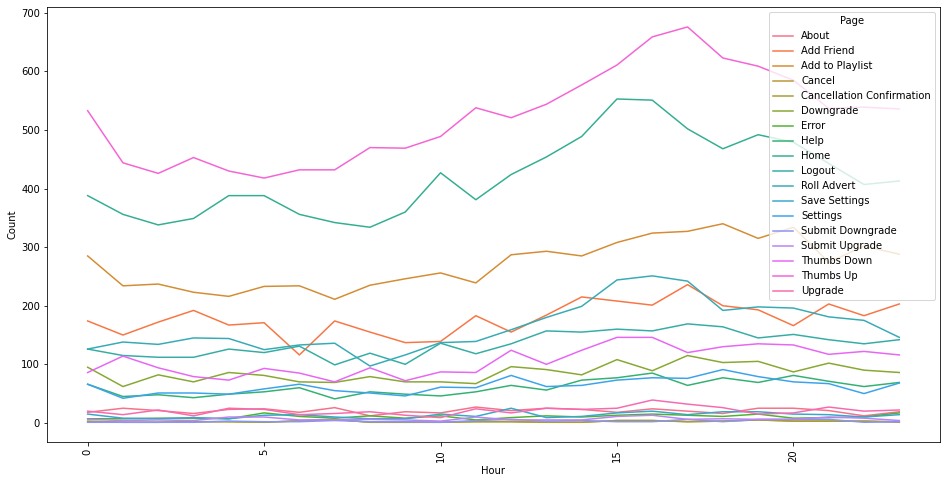

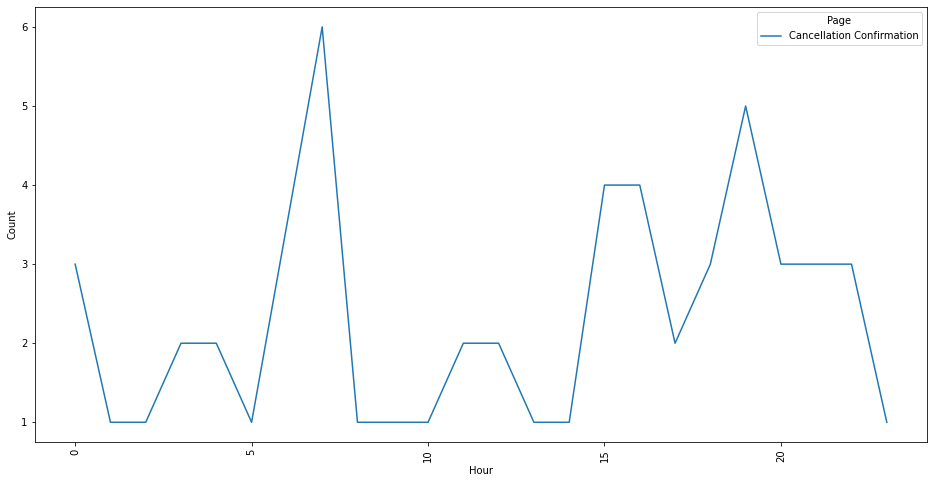

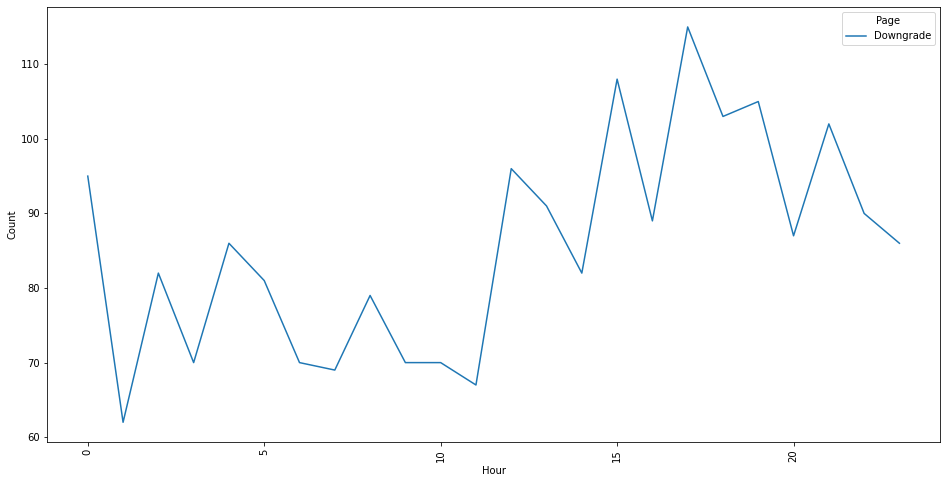

In [56]:
# plot page type 'NextSong' only
events_per_hour = df_clean.filter(col('page')=='NextSong').groupby('hour','page').count().sort('hour','page')

plot_line_chart(events_per_hour, 'hour', 'count', 'page')

#plot all page types except 'NextSong'
events_per_hour = df_clean.filter(col('page')!='NextSong').groupby('hour','page').count().sort('hour','page')

plot_line_chart(events_per_hour, 'hour', 'count', 'page')

#plot page type 'Cancellation Confirmation'
events_per_hour = df_clean.filter(col('page')=='Cancellation Confirmation').groupby('hour','page').count().sort('hour','page')

plot_line_chart(events_per_hour, 'hour', 'count', 'page')

#plot page type 'Downgrade'
events_per_hour = df_clean.filter(col('page')=='Downgrade').groupby('hour','page').count().sort('hour','page')

plot_line_chart(events_per_hour, 'hour', 'count', 'page')

### Churn Definition

A column `churn` is created to use as the label for a customer churn prediction model. All events with page = `Cancellation Confirmation` will be regarded as **customer churn events** regardless of free or paid subscription.

A column `downgrade` is created to use as the label for a customer downgrade predicition model. All events with page = `Downgrade` will be regarded as customer **downgrade-from-paid events** because they always happen from level = `paid`.

In [96]:
df_clean.filter(col('page')=='Cancellation Confirmation') \
        .groupby('page','level') \
        .count() \
        .sort('page','level') \
        .show() 

df_clean.filter(col('page')=='Downgrade') \
        .groupby('page','level') \
        .count() \
        .sort('page','level') \
        .show()

+--------------------+-----+-----+
|                page|level|count|
+--------------------+-----+-----+
|Cancellation Conf...| free|   21|
|Cancellation Conf...| paid|   31|
+--------------------+-----+-----+

+---------+-----+-----+
|     page|level|count|
+---------+-----+-----+
|Downgrade| paid| 2055|
+---------+-----+-----+



In [101]:
df_clean.filter(col('page')=='Cancellation Confirmation').select('page','level','userId') \
                 .dropDuplicates() \
                 .groupby('page','level') \
                 .count().show()

df_clean.filter(col('page')=='Downgrade').select('page','level','userId') \
                 .dropDuplicates() \
                 .groupby('page','level') \
                 .count().show()

+--------------------+-----+-----+
|                page|level|count|
+--------------------+-----+-----+
|Cancellation Conf...| free|   21|
|Cancellation Conf...| paid|   31|
+--------------------+-----+-----+

+---------+-----+-----+
|     page|level|count|
+---------+-----+-----+
|Downgrade| paid|  154|
+---------+-----+-----+

